This notebook tests the idea of using `shtns` to rotate data in the spherical coordinate system.

In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from FeaturePreprocessor import FeaturePreprocessor


In [2]:
""" Open a test file"""
input_file = "/home/obrienta/projects/TECA_data/landsea.nc"

ds = xr.open_dataset(input_file)

# extract the land mask data
lsmask = ds.LSMASK



In [3]:
""" Add a cross to the field, for verifying directions. """
# set the lat/lon of a test point
blat = 39.1653 # bloomington, in
blon = -86.5264 + 360 # bloomington, in

# draw a cross on the field so we can see the local north and east directions
clat = blat
clon = blon
sigma1 = 10
sigma2 = 1
a = 10
lon2d, lat2d = np.meshgrid(lsmask.lon, lsmask.lat)
cross_field = \
    a*np.exp(-((lat2d-clat)**2)/sigma1**2 - ((lon2d-clon)**2)/sigma2**2) + \
    a*np.exp(-((lat2d-clat)**2)/sigma2**2 - ((lon2d-clon)**2)/(3*sigma1)**2)

# add the cross field to the land sea mask
lsmask = lsmask + cross_field

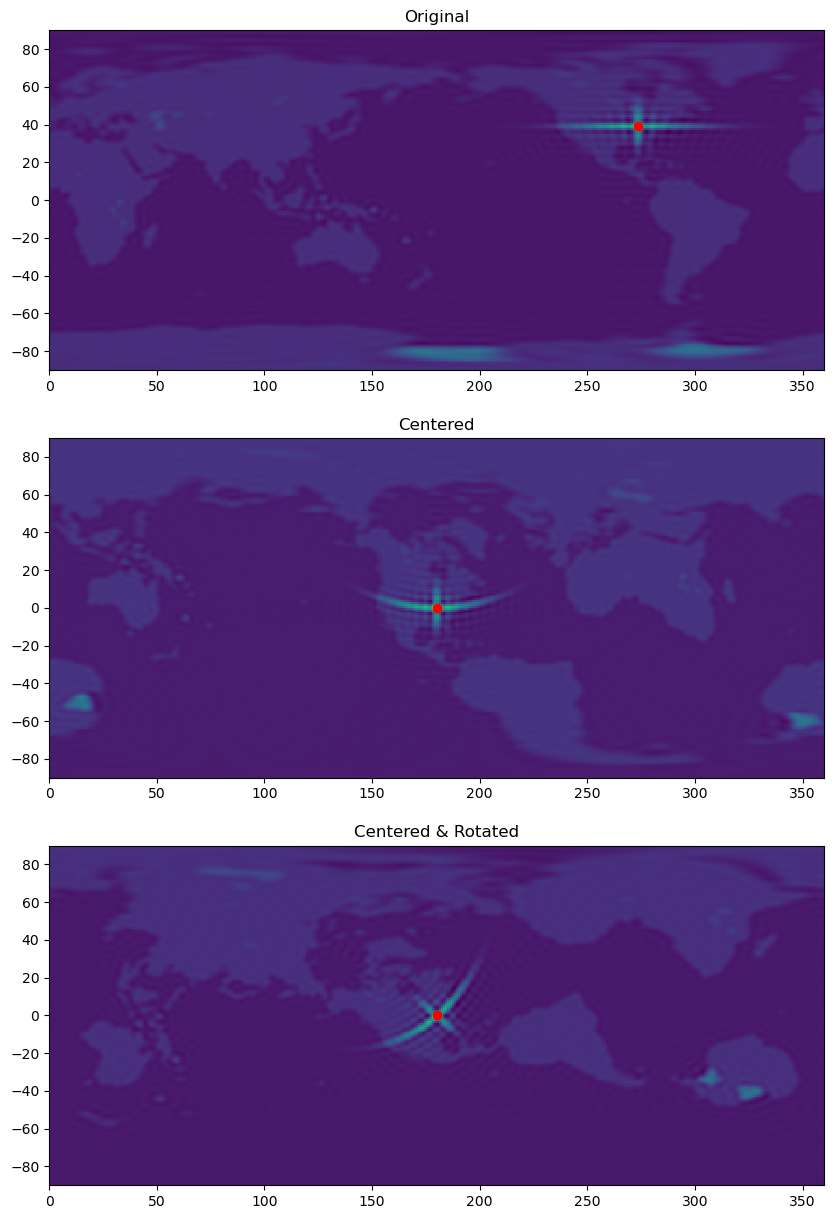

In [4]:
""" Demonstrate the FeaturePreprocessor class. """

preprocessor = FeaturePreprocessor(lsmask.lat, lsmask.lon, ntrunc=85, gridtype='regular')

fig, axs = plt.subplots(3,1, figsize=(10,15))

ax = axs[0]
# do/undo the spherical harmonic transform on the data so we see what the
# data look like after processing by the spherical harmonic transform
_tmp = preprocessor.transform.analys(lsmask.values.astype(np.float64))
lsmask_orig = preprocessor.transform.synth(_tmp)
ax.pcolormesh(lsmask.lon, lsmask.lat,lsmask_orig)
ax.plot(blon, blat, 'ro')
ax.set_title("Original")

ax = axs[1]
landmask_rotated = preprocessor.scalar_center_and_rotate(lsmask.values, blat, blon, angle=0)
ax.pcolormesh(lsmask.lon, lsmask.lat,landmask_rotated)
ax.plot(180,0, 'ro')
ax.set_title("Centered")

ax = axs[2]
# also test in-place rotation
landmask_rotated = np.array(lsmask.values, copy=True)
preprocessor.scalar_center_and_rotate(landmask_rotated, blat, blon, angle=45, inplace=True)
ax.pcolormesh(lsmask.lon, lsmask.lat,landmask_rotated)
ax.plot(180,0, 'ro')
ax.set_title("Centered & Rotated")

plt.savefig("sph_rotation_demo.png", dpi=300, bbox_inches="tight")

plt.show()

